# IBM Applied Data Science Capstone Project - The Battle of Neighborhoods
# Investigating the Optimal New Café Location in Zurich

## Hakki Karaman
#### 22.06.2020

## Table of Contents

0. <a href="#item1">Instuctions</a>
1. <a href="#item1">Introduction: Business Problem</a>
2. <a href="#item2">Data</a>  
3. <a href="#item3">Methodology</a>  
4. <a href="#item5">Results an Discussion</a> 
5. <a href="#item5">Conculusions</a> 

## Instructions
The final deliverables of the Capstone project will be:

**1. A full report consisting of all of the following components (15 marks):**

- Introduction where you discuss the business problem and who would be interested in this project.

- Data where you describe the data that will be used to solve the problem and the source of the data.

- Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

- Results section where you discuss the results.

- Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

- Conclusion section where you conclude the report.

**2. A link to your Notebook on your Github repository pushed showing your code. (15 marks)**

**3. Your choice of a presentation or blogpost. (10 marks)**

Here are examples of previous outstanding submissions that should give you an idea of what your report would look like, what your notebook would look like in terms of clean, clear, and well-commented code, and what your presentation would look like or your blogpost would look like:

Report: https://cocl.us/coursera_capstone_report

Notebook: https://cocl.us/coursera_capstone_notebook

Presentation: https://cocl.us/coursera_capstone_presentation

Blogpost: https://cocl.us/coursera_capstone_blogpost

## Introduction: Business Problem
This project aims to find the best location to open a new cafe at the center of Zurich (District 1-6). **The business problem is finding the optimal district for the prospective café by finding out the district with the lowest number of cafes per capita.**

Many similar studies were done in past to find out the optimal location for a new business, usually the frequency of the cafes/ restaurants/ shops and the distance to the center were taken into consideration however the population of the districts are neglected. The frequency of restaurants gives idea of the supply and the number of people living in the district is essential to find out the demand. **For each district, the key parameter restaurant per capita can be calculated with the number of cafes in the district divided by the population of the district.** 

Let's import all necessary libraries and install the environments

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         393 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

In [3]:
import matplotlib.pyplot as plt
import requests

## Data
To be compare the number of restaurant per capita for each district we need to main source of data:

1. Population of each district: District populations of Zurich can be find in Wikipedia page: https://en.wikipedia.org/wiki/Z%C3%BCrich#Population

2. The exact coordinates of chosen center  Number of restaurants per district: Foursquare developer account has the data: https://developer.foursquare.com/

In [4]:
#The population of all 12 districts of Zurich (Disctrict 1-12)
population = [5617, 31603, 49195, 28701, 15065, 32867, 37053, 16192, 51328, 38199, 72831, 31753]


2.Number of cafes per district: I used my Foursquare developer account to have the locations of the cafes. It will be necessary to explore data to develop a strategy to find out the district. https://developer.foursquare.com/

In [5]:
CLIENT_ID = 'ZBEHSZWUMHIUDFDTM1RVT4PQEFKX3EQPQCSVVAEZUKBNCLMJ' # my Foursquare ID
CLIENT_SECRET = 'MTVRVZ5WTVICIXXSS22O5ONBHWXRMYXNMDPXV31SXBICR0GN' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZBEHSZWUMHIUDFDTM1RVT4PQEFKX3EQPQCSVVAEZUKBNCLMJ
CLIENT_SECRET:MTVRVZ5WTVICIXXSS22O5ONBHWXRMYXNMDPXV31SXBICR0GN


Now, it is the time to find out coordinates of the chosen center point and then vicinity of the search from this center will be determined. Zurich HB (Zurich main train station) is the center of Zurich, let's find out accurate coordinates of it!

In [6]:
address = 'Zurich HB, Switzerland'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The latitude and longitude of', address, 'are', latitude, longitude)

The latitude and longitude of Zurich HB, Switzerland are 47.3781008 8.5393635


This 3 km radius is safe to cover all the central districts, later on the number of cafes in each district will be find out.

In [7]:
search_query = 'Cafe' # we are looking for cafes
#radius is chosen big enough to cover entire Zurich City
radius = 3000 #in meters
print(search_query + ' .... OK!')

Cafe .... OK!


In [8]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query , radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=ZBEHSZWUMHIUDFDTM1RVT4PQEFKX3EQPQCSVVAEZUKBNCLMJ&client_secret=MTVRVZ5WTVICIXXSS22O5ONBHWXRMYXNMDPXV31SXBICR0GN&ll=47.3781008,8.5393635&v=20180604&query=Cafe&radius=3000&limit=1000'

In [9]:
results = requests.get(url).json()

In [10]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.neighborhood
0,53a57c62498e34ef9a4f6d69,Café Oscar,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1592832006,False,Bahnhofplatz 15,Südtrakt,47.377776,8.539513,"[{'label': 'display', 'lat': 47.377776, 'lng':...",37,8001,CH,Zürich,Zürich,Schweiz,"[Bahnhofplatz 15 (Südtrakt), 8001 Zürich, Schw...",NaN,NaN
1,4be416f1cf200f472e72113c,Gran Café Motta,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1592832006,False,Limmatquai 66,Rathaus,47.372346,8.542754,"[{'label': 'display', 'lat': 47.37234591508398...",689,8001,CH,Zürich,Zürich,Schweiz,"[Limmatquai 66 (Rathaus), 8001 Zürich, Schweiz]",94120877,NaN
2,4b058888f964a52009cc22e3,Café Schober,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1592832006,False,Napfgasse 4,NaN,47.371400,8.544149,"[{'label': 'display', 'lat': 47.37139957891544...",828,8001,CH,Zürich,Zürich,Schweiz,"[Napfgasse 4, 8001 Zürich, Schweiz]",NaN,NaN
3,4b9cac05f964a520997536e3,Café Wühre,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1592832006,False,Wuhre 11,NaN,47.370761,8.542010,"[{'label': 'display', 'lat': 47.37076065788582...",841,NaN,CH,Zürich,Zürich,Schweiz,"[Wuhre 11, Zürich, Schweiz]",NaN,NaN
4,51af8be6498ea309db82eb84,Café du Bonheur,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1592832006,False,Zypressenstrasse 115,NaN,47.379697,8.516199,"[{'label': 'display', 'lat': 47.37969690117899...",1755,8004,CH,Zürich,Zürich,Schweiz,"[Zypressenstrasse 115, 8004 Zürich, Schweiz]",NaN,NaN


In [11]:
dataframe.shape

(50, 19)

## Methodology 

For each district (district_i where i= {1,2,3,4,5,6}) the number of cafes per capita can be found by dividing the number of cafes of the district to its population

As we have already had the population information for each district, now we need to find out the number of cafes for each district. The first idea would be finding out the districts based on latitude & longitude information of the cafes and finding out the districts thanks to GeoPy and Folium libraries of Python. However, there is an easier way for someone who is familiar with the postal code of Zurich. The last 2 digits of Zurich postal code represents the district, for example if the postal code is 8005, it is the 5th district.

In [12]:
#keeping the location relevant information
filtered_columns = ['name', 'location.lat', 'location.lng','location.distance', 'location.postalCode','location.formattedAddress'] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head(10)

,name,lat,lng,distance,postalCode,formattedAddress,id
0,Café Oscar,47.377776,8.539513,37,8001,"[Bahnhofplatz 15 (Südtrakt), 8001 Zürich, Schw...",53a57c62498e34ef9a4f6d69
1,Gran Café Motta,47.372346,8.542754,689,8001,"[Limmatquai 66 (Rathaus), 8001 Zürich, Schweiz]",4be416f1cf200f472e72113c
2,Café Schober,47.371400,8.544149,828,8001,"[Napfgasse 4, 8001 Zürich, Schweiz]",4b058888f964a52009cc22e3
3,Café Wühre,47.370761,8.542010,841,NaN,"[Wuhre 11, Zürich, Schweiz]",4b9cac05f964a520997536e3
4,Café du Bonheur,47.379697,8.516199,1755,8004,"[Zypressenstrasse 115, 8004 Zürich, Schweiz]",51af8be6498ea309db82eb84
5,Café Gourmet,47.377094,8.539425,112,8001,"[Bahnhofplatz 7, 8001 Zürich, Schweiz]",4b8e149ff964a520c81733e3
6,A Confectioner's Café,47.378153,8.539920,42,8001,"[Migros, Bahnhofstrasse 21. 8001 Zurich, Switz...",572c8b3bcd10a820361648f8
7,Le Cafe,47.377857,8.540275,73,8001,"[Hauptbahnhof, 8001 Zürich, Schweiz]",4bc8acc5ab62d13a90c317d4
8,Restaurant Cafe Boy,47.377926,8.516215,1745,8004,"[Kochstr. 2, 8004 Zürich, Schweiz]",4bb3353c4019a5935c9e37b8
9,Grande Café & Bar,47.375479,8.543395,421,8001,"[Limmatquai 118, 8001 Zürich, Schweiz]",504a0c0f19a9a1bc79aae89a


In [105]:
dataframe_filtered.name

0                    Café Oscar
1               Gran Café Motta
2                  Café Schober
3                    Café Wühre
4               Café du Bonheur
5         A Confectioner's Café
6                  Café Gourmet
7                       Le Cafe
8           Restaurant Cafe Boy
9             Grande Café & Bar
10             Café Buttermilch
11        Big Bang Cafe @Google
12               Milliways Cafe
13               Breitling Cafe
14           Cellini Café & Bar
15                   Cafe Uetli
16      Confiserie & Cafe Bauer
17    le Cafe en Soie by Vicafe
18                Café Milchbar
19      Paulo's Cafe Restaurant
20             café côte d'azur
21    Lotti Restaurant Bar Cafe
22                   Café Elena
23                    Café Lang
24         City Cafe bar Lounge
25                Cafe Schurter
26                 Cafe Central
27                    City Cafe
28         Cafe Leonhardstreppe
29               Café Zähringer
30                    Café Noir
31      

In [13]:
NumberofBarPerDistrict = dataframe_filtered.groupby('postalCode').count().name
print(NumberofBarPerDistrict)

postalCode
8001    16
8002     2
8003     3
8004     4
8005     3
8006     2
8037     1
Name: name, dtype: int64


In [14]:
type(NumberofBarPerDistrict)

pandas.core.series.Series

In [15]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Zurich HB

# add a red circle marker to represent the Zurich HB
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add Zurich HB as blue circle markers
#for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
for lat, lng in zip(dataframe_filtered.lat, dataframe_filtered.lng):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        #popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

In [16]:
dataframe_filtered.groupby('postalCode').count().name.values[0:6]

array([16,  2,  3,  4,  3,  2])

In [17]:
dataframe_filtered.shape

(50, 7)

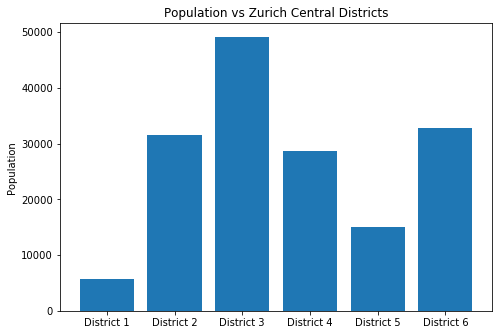

In [18]:
fig1 = plt.figure()
ax = fig1.add_axes([0,0,1,1])
districts = ['District 1', 'District 2', 'District 3', 'District 4', 'District 5', 'District 6']
ax.bar(districts,population[0:6])
ax.set_ylabel('Population')
ax.set_title('Population vs Zurich Central Districts')
plt.show()

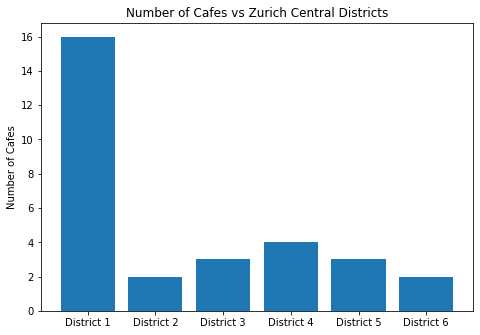

In [19]:
fig2 = plt.figure()
ax = fig2.add_axes([0,0,1,1])
ax.bar(districts,NumberofBarPerDistrict.values[0:6])
ax.set_ylabel('Number of Cafes')
ax.set_title('Number of Cafes vs Zurich Central Districts')
plt.show()

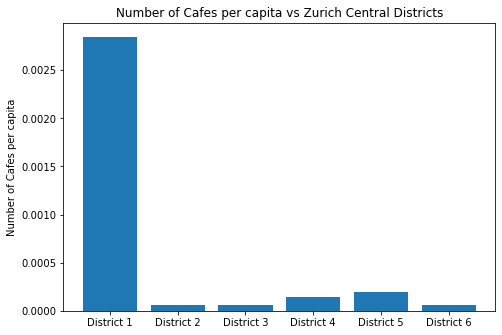

In [20]:
fig3 = plt.figure()
ax = fig3.add_axes([0,0,1,1])
NumberofBarPerDistrictPerCapita=(NumberofBarPerDistrict.values[0:6]/population[0:6])
ax.bar(districts,NumberofBarPerDistrictPerCapita)
ax.set_ylabel('Number of Cafes per capita')
ax.set_title('Number of Cafes per capita vs Zurich Central Districts')
plt.show()

## Results and Discussion 

The next task is to calculate the number of cafes per capita. In figure below, it can be observed District 1 has order of magnitude higher value. Although, District 1 is smallest one, it contains both the historical center and the business center of the city. So, there are a lot of offices and stores for business, tourism, shopping and not many residential buildings. So, its population lowest but it has the highest number of cafes.

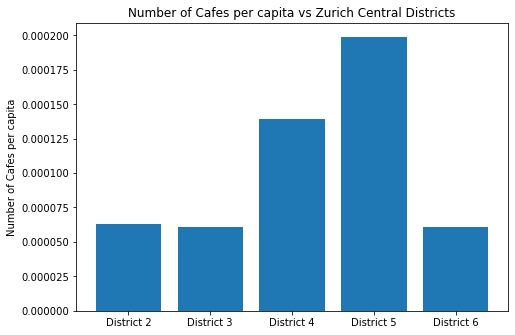

In [21]:
fig3 = plt.figure()
districts_2_6 = ['District 2', 'District 3', 'District 4', 'District 5', 'District 6']
ax = fig3.add_axes([0,0,1,1])
NumberofBarPerDistrictPerCapita_excludingDistrict1=(NumberofBarPerDistrict.values[1:6]/population[1:6])
ax.bar(districts_2_6,NumberofBarPerDistrictPerCapita_excludingDistrict1)
ax.set_ylabel('Number of Cafes per capita')
ax.set_title('Number of Cafes per capita vs Zurich Central Districts')
plt.show()

In [22]:
print('The Optimal Location in the Center of Zurich to open a new cafe is District ' + str(np.argmin(NumberofBarPerDistrictPerCapita)+1))

The Optimal Location in the Center of Zurich to open a new cafe is District 6


In [23]:
NumberofBarPerDistrictPerCapita

array([2.84849564e-03, 6.32851312e-05, 6.09818071e-05, 1.39367966e-04,
       1.99137073e-04, 6.08513098e-05])

## Conclusion

This study was done to find out the optimal district to open up a new café by using available data. The characteristic parameter is defined as number of cafes per number of residents in the district. The population of the districts was found in Wikipedia and the number of cafes per district was found by practically using the postal code of the cafes from Foursquare data.
According to the analysis, District 6 is the optimal place for a new café as it has the minimum value for number of cafes per capita. It is important to mention that District 2 and District 3 are also very close to the minimum value and the difference is not significant. As a future work one can consider to develop more sophisticated model to compare District 2-3-6 with further data such as the rent prices, the available locations with their location of the district, the flow of non-resident people etc.